### Final Project coding File
### Course: CS 6010 (Data Science Programming)
### Course Instructor: Dr. Qing Tian
### Submitted By Md Kamrul Islam

### Topic:Land Cover and Land Use Classification Using Satellite Imagery and Convolutional Neural Networks

## Importing libraries

In [2]:
import os, glob
import numpy as np
! pip install pyrsgis
from pyrsgis import raster

Connecting with my google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Specifiy my working directory

In [4]:
import os
os.chdir('/content/drive/MyDrive/Colabfolder')

  Importing training image tif file and lable tif file
####  Converting traing images into small chips 

In [5]:
import numpy as np
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromFile

# define the file names
#feature_file = r"E:\CNN_Builtup\l5_Bangalore2011_raw.tif"
label_file = r"/content/drive/MyDrive/Colabfolder/ctglvl.tif"

## ctg_training file means input training raw image, that has been converted into small chips
from pyrsgis import raster, ml
infile = r'/content/drive/MyDrive/Colabfolder/ctg_training.tif' 
ds, data_arr = raster.read(infile)
features = ml.array_to_chips(data_arr, y_size=7, x_size=7)
print('Shape of input array:', data_arr.shape)
print('Shape of generated image chips:', features.shape)

features = np.rollaxis(features, 3, 1)

# read the label file and reshape it
ds, labels = raster.read(label_file)
labels = labels.flatten()

# check for irrelevant values (we are interested in 3s and non-1s) because in label image our built area labeled as 3.
labels = (labels == 3).astype(int)

# print basic details
print('Input features shape:', features.shape)
print('\nInput labels shape:', labels.shape)
print('Values in input features, min: %d & max: %d' % (features.min(), features.max()))

Shape of input array: (7, 889, 491)
Shape of generated image chips: (436499, 7, 7, 7)
Input features shape: (436499, 7, 7, 7)

Input labels shape: (436499,)
Values in input features, min: -33 & max: 6568


In [6]:
## Saving array for further use
np.save('CNN_7by7_features.npy', features)
np.save('CNN_7by7_labels.npy', labels)

In [7]:
features = np.load('CNN_7by7_features.npy')
labels = np.load('CNN_7by7_labels.npy')

# Separate and balance the classes
built_features = features[labels==1]
built_labels = labels[labels==1]

unbuilt_features = features[labels==0]
unbuilt_labels = labels[labels==0]

print('Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

Number of records in each class:
Built: 105177, Unbuilt: 331322


In [8]:
# Combine the balanced features
features = np.concatenate((built_features, unbuilt_features), axis=0)
labels = np.concatenate((built_labels, unbuilt_labels), axis=0)

# Normalise the features( our maximum DN value is 6568), we can also use normalize function here.
features = features / 6568
print('New values in input features, min: %d & max: %d' % (features.min(), features.max()))

New values in input features, min: 0 & max: 1


importing libraies for CNN mmodel

In [9]:
import random
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, Activation

### Defining lables, data set processing and train, test split

In [10]:

# Define the function to split features and labels
def train_test_split(features, labels, trainProp=0.6):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)
  
# Call the function to split the data
train_x, train_y, test_x, test_y = train_test_split(features, labels)

train_x = tf.transpose(train_x, [0, 2, 3, 1])
test_x = tf.transpose(test_x, [0, 2, 3, 1])

print('Reshaped split features:', train_x.shape, test_x.shape)
print('Split labels:', train_y.shape, test_y.shape)

Reshaped split features: (261899, 7, 7, 7) (174600, 7, 7, 7)
Split labels: (261899,) (174600,)


## Defining model

In [12]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(7, 7, 7)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          256       
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 48)          1584      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 48)          0         
                                                                 
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 64)                150592    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [13]:
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer= 'rmsprop',metrics=['accuracy'])


In [14]:
# Running model
history = model.fit(train_x, train_y, epochs=20, batch_size=40, validation_split=0.2)

Epoch 1/20
5238/5238 [==============================] - 43s 6ms/step - loss: 0.1123 - accuracy: 0.9535 - val_loss: 0.1017 - val_accuracy: 0.9569
Epoch 2/20
5238/5238 [==============================] - 34s 7ms/step - loss: 0.1032 - accuracy: 0.9581 - val_loss: 0.0982 - val_accuracy: 0.9582
Epoch 3/20
5238/5238 [==============================] - 34s 7ms/step - loss: 0.1018 - accuracy: 0.9586 - val_loss: 0.1052 - val_accuracy: 0.9522
Epoch 4/20
5238/5238 [==============================] - 35s 7ms/step - loss: 0.1009 - accuracy: 0.9588 - val_loss: 0.0949 - val_accuracy: 0.9605
Epoch 5/20
5238/5238 [==============================] - 32s 6ms/step - loss: 0.1020 - accuracy: 0.9591 - val_loss: 0.0871 - val_accuracy: 0.9641
Epoch 6/20
5238/5238 [==============================] - 33s 6ms/step - loss: 0.1010 - accuracy: 0.9595 - val_loss: 0.0898 - val_accuracy: 0.9617
Epoch 7/20
5238/5238 [==============================] - 35s 7ms/step - loss: 0.1002 - accuracy: 0.9590 - val_loss: 0.0872 - val_ac

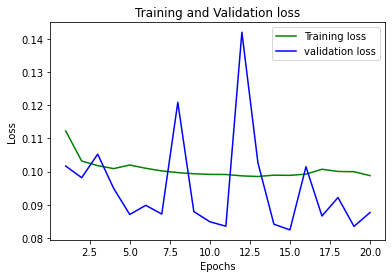

In [15]:
### Ploting training and validation loss
from matplotlib import pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
## Evaluating model with test data for getting the accuracy
model.evaluate(test_x, test_y)

5457/5457 [==============================] - 27s 5ms/step - loss: 0.0879 - accuracy: 0.9632


[0.08792979270219803, 0.9632359743118286]

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict for test data and find the model evaluation criteria
yTestPredicted = model.predict(test_x)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted)
rScore = recall_score(test_y, yTestPredicted)
fscore = f1_score(test_y, yTestPredicted)

print("Confusion matrix:\n", cMatrix)

print(pScore, rScore, fscore)

Confusion matrix:
 [[130726   1930]
 [  4489  37455]]
0.9509965722990986 0.892976349418272 0.9210736637607742


### Now we can predict and produce landuse and landcover image in tif format
### This image are in Binary data, 1 indicates the buit area and 0 indicates Unbit area

In [18]:
## Frist pridiect the land use and land cover of 2021
## Agin, we need to generate image chips from array, because we have to feed the input file as same format of model
## this time we are generating image chips from array because we needed the datasource object (ds) to export the TIF file
## And since we are reading the TIF file anyway, why not use the array directly

from pyrsgis import raster, ml

infile_new = r"/content/drive/MyDrive/Colabfolder/raw_image_2021.tif"
ds, data_arr_new = raster.read(infile_new)
new_features = ml.array_to_chips(data_arr_new, y_size=7, x_size=7)


print('Shape of the new features', new_features.shape)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features)
#print("Shape of the predicted labels: ", newPredicted.shape)
newPredicted = newPredicted[:,1]

prediction = np.reshape(newPredicted, (ds.RasterYSize, ds.RasterXSize))

outFile = 'ctg_classified_image_2021.tif'
raster.export(prediction, ds, filename=outFile, dtype='float')

Shape of the new features (436499, 7, 7, 7)


In [19]:
### Land cover detection of 2014
from pyrsgis import raster, ml

infile_new = r"/content/drive/MyDrive/Colabfolder/ctg_raw_2014.tif"
ds, data_arr_new = raster.read(infile_new)
new_features_2014 = ml.array_to_chips(data_arr_new, y_size=7, x_size=7)


print('Shape of the new features', new_features_2014.shape)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features_2014)
#print("Shape of the predicted labels: ", newPredicted.shape)
newPredicted = newPredicted[:,1]

prediction = np.reshape(newPredicted, (ds.RasterYSize, ds.RasterXSize))

outFile = 'ctg_classified_2014.tif'
raster.export(prediction, ds, filename=outFile, dtype='float')

Shape of the new features (436499, 7, 7, 7)


These output image are in tiff format and are in gray output where there are two data value(1 & 0) in the image. One indicates the built area and zero indicates unbuilt area. This file can be open with and remote sensing or gis software and produec color map with neccessary legand, north arrow and scale.